<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# NLP Part 3: Spam Classification 

### Learning Objectives

- Implement `CountVectorizer` and `TfidfVectorizer` in a spam classification model.
- Use `GridSearchCV` and `Pipeline` with `CountVectorizer`.

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Spam Classification Model

One common application of NLP is predicting "spam" vs. "ham," or "spam" vs. "not spam."

Can we predict real vs. promotional texts just based on what is written?

> This data set was taken from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) and consists of SMS messages that have been labeled as either "spam" or "ham". 

# Reminder of the Data Science Process
1. Define problem.
2. Gather data.
3. Explore data.
    - Yes, we can still do EDA with text data!
    - We also have to pre-process our text data to prepare it for modeling.
4. Model with data.
5. Evaluate model.
6. Answer problem.

In [2]:
# Read in data.
spam = pd.read_csv('data/SMSSpamCollection',
                 sep='\t',
                 names=['label', 'message'])

# Check out first five rows.
spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
spam.size

11144

## Let's get our data
---

Convert ham/spam into binary labels. We are interested in identifying spam, so set spam as the event of interest (value of 1) 
- 0 for ham
- 1 for spam

In [4]:
spam['label'] = spam['label'].map({'ham': 0, 'spam': 1})
spam.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Let's set up our data for modeling:
- `X` will be the `message` column. **NOTE**: `CountVectorizer` requires a vector, so make sure you set `X` to be a `pandas` Series, **not** a DataFrame.
- `y` will be the `label` column

In [5]:
X = spam['message']
y = spam['label']

In [6]:
# Check what we need to check in a classification problem - how many of each event
y.value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

In [7]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

## `CountVectorizer`
---

Now we can use the `CountVectorizer` to transform the training data to a Term-Document Matrix, before applying a classification model.


In [8]:
# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer()

In [9]:
# Fit the vectorizer on our corpus (find all the tokens)
cvec.fit(X_train)

CountVectorizer()

In [10]:
# Transform the corpus to a matrix by calculating the occurrences of each token
X_train_tdm = cvec.transform(X_train)

In [11]:
# X_train is now a term-document matrix
X_train_tdm

<3733x6935 sparse matrix of type '<class 'numpy.int64'>'
	with 49422 stored elements in Compressed Sparse Row format>

In [12]:
# few of the features
cvec.get_feature_names_out()[1000:1010]

array(['asked', 'askin', 'asking', 'asks', 'aslamalaikkum', 'asleep',
       'asp', 'aspects', 'ass', 'assessment'], dtype=object)

In [13]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train_tdm.todense(), 
                          columns=cvec.get_feature_names_out())
X_train_df.head()

,00,000,000pes,008704050406,0089,0121,01223585334,02,0207,02072069400,...,zed,zeros,zhong,zindgi,zoe,zogtorius,zyada,èn,ú1,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


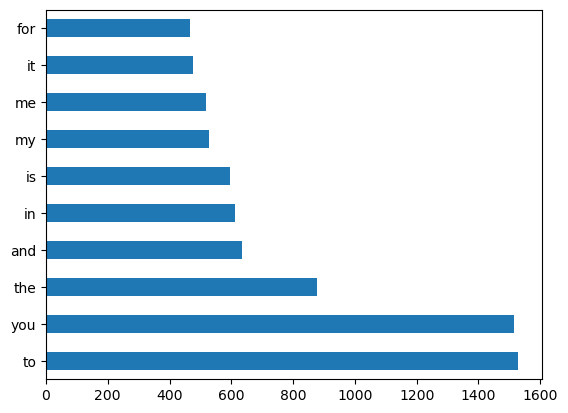

In [14]:
# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

## Modelling the Data

At this point, we could fit a model (like a logistic regression model or $k$-nearest neighbors model) using our transformed data, or continue doing more pre-processing such as tokenizing, lemmatizing or stemming.

Let's try to fit a classification model first.





## Naïve Bayes

We will try to use a Naïve Bayes classifier. Naïve Bayes relies on [Bayes theorem](https://www.mathsisfun.com/data/bayes-theorem.html), which is based on conditional probabilities.


If we know $P(B|A)$, Bayes theorem allows us to calculate the probability of $P(A|B)$ by relating the probability of $P(A|B)$ to $P(B|A)$. 

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

- Let $A$ be that a message is spam.
- Let $B$ represent the words used in the message.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)} \\
\Rightarrow P(\text{message is spam}|\text{words in message}) &=& \frac{P(\text{words in message}|\text{message is spam})P(\text{message is spam})}{P(\text{words in message})}
\end{eqnarray*}
$$

We want to calculate the probability that a post is spam **given** the words that are in the message! Our model can learn this from the training data.

**Naïve Bayes** makes the assumption that all features are independent of one another (this is why it is called *naïve*).

<details><summary>Why is this assumption not realistic with our data?</summary>
    
Text data is never independent! Words have different context when they appear together.
</details>

Despite this assumption not being realistic with NLP data, we still use Naïve Bayes pretty frequently.
- It's a very fast modeling algorithm (which is great especially when we have lots of features and/or lots of data!).
- It is often an excellent classifier, outperforming more complicated models.

There are three common types of Naive Bayes models: Bernoulli Naive Bayes, Multinomial Naive Bayes, and Gaussian Naive Bayes.
- How do we pick which of the three models to use? It depends on our $X$ variable.
    - [Bernoulli Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB): when we have predictor variables with binary 0/1 values
    - [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB): when our predictor variables are positive integers.
    - [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB): when our features are Normally distributed.
    
Let's try to fit the `MultinomialNB` classifer.

In [15]:
# Instantiate the classifier
mb = MultinomialNB()

# fit on the transformed X_train data
mb.fit(X_train_tdm, y_train)

MultinomialNB()

In [16]:
# get accuracy score on training data
mb.score(X_train_tdm, y_train)

0.993302973479775

## Evaluation

As always, we have to evaluate the model on our test data. But remember we have to transform the test data into a term document matrix as well before it can be scored.


In [17]:
# Transform X_test by calculating the occurrences of each token already defined by X_train
X_test_tdm = cvec.transform(X_test)
X_test_tdm

<1839x6935 sparse matrix of type '<class 'numpy.int64'>'
	with 22719 stored elements in Compressed Sparse Row format>

## Baseline accuracy

We need to calculate baseline accuracy in order to tell if our model is better than null model (predicting the plurality class).

In [18]:
y_test.value_counts(normalize=True)

0    0.865688
1    0.134312
Name: label, dtype: float64


<details><summary>What is the baseline accuracy?</summary>
    
- If the value '0' occurs 87% of the time in our dataset, this means that if we predicted 'ham' all the time, we would have an accuracy of 87%.

Our baseline accuracy is thus 87%.

</details>

In [19]:
# Score the test data
mb.score(X_test_tdm, y_test)

0.9853181076672104

### Prediction

Not bad! We can now use the model to obtain predictions on the test data.

In [20]:
# Get predictions
preds = mb.predict(X_test_tdm)


In [21]:

# Save confusion matrix values
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

In [22]:
fn

22

In [23]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.996859296482412


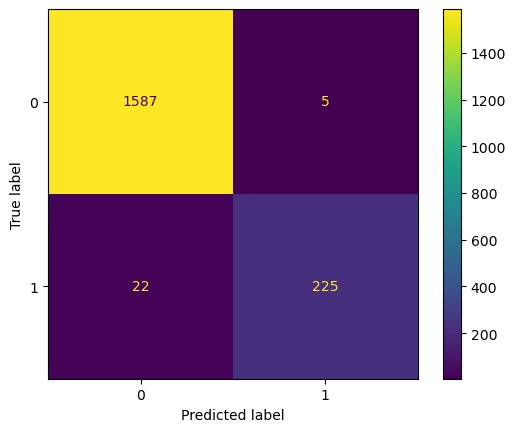

In [24]:
# View confusion matrix

cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()


## Hyperparameters, Gridsearch and Pipelining


Maybe we need to adjust our hyperparameters. But what values should be set for:

`max_features`
`min_df`
`max_df`
`ngram_range`

that will give us the best prediction of whether a message is spam or ham? Looking at the plot of top occurring words, should we remove stopwords?

We will need to use a gridsearch to search through the possible hyperparameters to obtain the best model.

But first we should set up the pipeline.

## Setting up the Pipeline

<details><summary>Is CountVectorizer an estimator or a transformer?</summary>
    
- A transformer.
</details>

<details><summary>Why do we need a pipeline to GridSearch over our CountVectorizer hyperparameters?</summary>
    
- The CountVectorizer is a transformer.
- Transformers have .fit() and .transform() methods, but cannot do .predict().
- In order to GridSearch over hyperparameters, we need some way to score our model performance.
- A pipeline stacks together one or more transformers with an estimator at the end. The estimator allows us to .predict() and get a score!
</details>

In [25]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [26]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

## `GridSearchCV`
---

At this point, you could use your `pipeline` object as a model:

```python
# Estimate how your model will perform on unseen data
cross_val_score(pipe, X_train, y_train, cv=3).mean() 

# Fit your model
pipe.fit(X_train, y_train)

# Training score
pipe.score(X_train, y_train)

# Test score
pipe.score(X_test, y_test)
```

Since we want to tune over the `CountVectorizer`, we'll load our `pipeline` object into `GridSearchCV`.

First set up the hyperparameter values for `CountVectorizer`:

In [27]:
# Search over the following values of hyperparameters:
# Stopwords: use 'english', or None
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__stop_words' : ['english', None],
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [28]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

<details><summary>How many models are we fitting here?</summary>

- 2 stop_words options
- 4 max_features
- 2 min_df
- 2 max_df
- 2 ngram_range
- 5-fold CV
- 2 * 4 * 2 * 2 * 2 * 5 = 320 models
</details>

In [29]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None]})

In [30]:
# what were the best hyperparameters?
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [31]:
# What's the best score?
print(gs.best_score_)

0.9852668942077514


In [32]:
# Score model on training set.
gs.score(X_train, y_train)

0.991159924993303

In [33]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9847743338771071

<details><summary>Is accuracy the best score here?</summary>

Since we are classifying whether or not a message is spam, I care more about minimizing false positives here (maximizing for specificity). I prefer for my important emails to go to my inbox (true negatives) and potentially have a few spam messages go to my inbox (false negative) than miss an important email that was incorrectly classified as spam (false positive). 
</details>

In [34]:
# Get predictions
preds = gs.predict(X_test)


In [35]:
# View confusion matrix
cm = confusion_matrix(y_test, preds)
cm

array([[1587,    5],
       [  23,  224]], dtype=int64)

In [36]:
# Calculate the specificity
tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.996859296482412


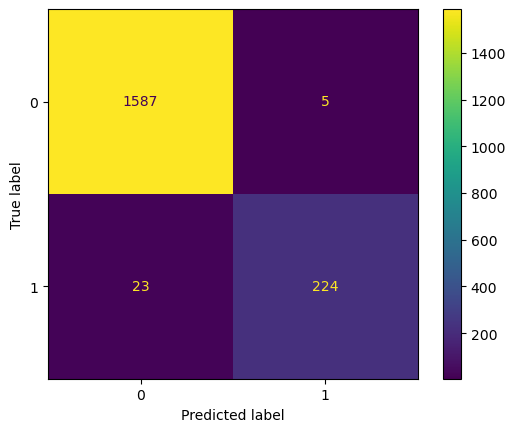

In [37]:
# View confusion matrix
cm_disp=ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()

### Review: Practice Using the `TfidfVectorizer`


As you did above, instantiate the default `TfidfVectorizer`, then fit the spam and ham data.

In [38]:
# Instantiate and fit the transformer.
tvec = TfidfVectorizer()

### Modeling Using the `TfidfVectorizer`

Let's set up a pipeline using tf-idf and Multinomial Naive Bayes.

<details><summary>What's the problem with this?</summary>

- Technically, we are supposed to have positive integers to use Multinomial Naive Bayes. Tf-idf does not give us positive integers.
- However, it will still work. Even the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) says "The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work."
</details>

In [39]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])


In [40]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_params = {
    'tvec__stop_words' : ['english', None],
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [41]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [42]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.


In [43]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english', None]})

In [44]:
# Score model on training set.
gs.score(X_train, y_train)

0.9879453522635949

In [45]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9815116911364872

In [46]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()
# Calculate the specificity
specificity = tn / (tn + fp)
print(specificity)

1.0


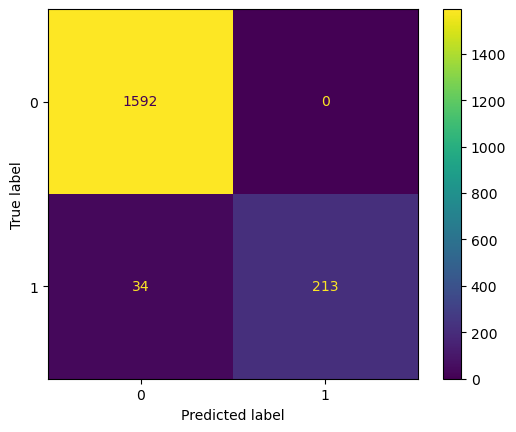

In [47]:
# visualize this
cm_disp=ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()


Which model gives us a higher *specificity*?
- `CountVectorizer`, or `TfidfVectorizer`?